<a href="https://colab.research.google.com/github/Pbonmars-20031006/Assignment-1/blob/main/Assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyqtree
!pip install Rtree
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io
import timeit
import random
from pyqtree import Index
from rtree import index as rtree_index  # Use an alias for the imported module
from rtree import index
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from google.colab import files
import io

  Preparing metadata (setup.py) ... done
  Created wheel for pyqtree: filename=Pyqtree-1.0.0-py3-none-any.whl size=5968 sha256=08305ca27e93c71e509167555f7e11d38c488983d3a1d5c187373f33dd7646e5
  Stored in directory: /root/.cache/pip/wheels/63/e6/90/6e15bfb4299fd41f88a9affca879f44bde40d3dc6f398462a8
Successfully built pyqtree
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 535.2/535.2 kB 5.5 MB/s eta 0:00:00


In [ ]:
# a class named rectdetails to store all the details of a given rectangle, helping in easy of access
class RectDetails:
    def __init__(self , rectangle_id, left_bottom_x, left_bottom_y, right_top_x, right_top_y):
        self.rectangle_id = rectangle_id  # stores the id of the rectangle
        self.left_bottom_corner_x = left_bottom_x  #stores the left bottom x coordinate
        self.left_bottom_corner_y = left_bottom_y  #stores the left bottom y coordinate
        self.right_top_corner_x = right_top_x #stores the right bottom x coordinate
        self.right_top_corner_y = right_top_y #stores the right bottom x coordinate


In [ ]:
#a function to read rectangles from the input file
def read_rectangles_from_file(file_content):
    rectangles = []
    for line in file_content:
        try:
            data = list(map(int, line.strip('{}\n, ').split(',')))
            rectangles.append(data)
        except ValueError:
            pass
    return rectangles

In [ ]:
#function for creatioon of r-tree
def batch_insert_rtree(idx, rectangles):
    for rect_params in rectangles:
        rect_instance = RectDetails(*rect_params)
        bbox = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y,
                rect_instance.right_top_corner_x, rect_instance.right_top_corner_y)
        idx.insert(rect_instance.rectangle_id, bbox)

In [ ]:
#fucntion for plotting the rectangles using patches library
def plot_rect(ax, position, size, rectangle_id):
    edge_color = 'black'
    face_color = (random.random(), random.random(), random.random(), 0.5)
    rectangle = patches.Rectangle(position, size[0], size[1], edgecolor=edge_color, facecolor=face_color,)
    ax.add_patch(rectangle)

    # Display rectangle ID as a label inside the rectangle
    ax.text(position[0] + size[0] / 2, position[1] + size[1] / 2, str(rectangle_id),
            color='white', ha='center', va='center', fontsize=8)


In [ ]:
#a function to find all the enclosing rectangles using rtree
def find_enclosing_rectangles_rtree(point, rtree_idx):
    enclosing_rectangles = []
    x, y = point

    for rect_id in rtree_idx.intersection((x, y, x, y)): # finds intersection in all the nodes of rtree
        enclosing_rectangles.append(rect_id)

    return enclosing_rectangles

In [ ]:
#function to find all the enclosing rectangles using naive method of running forloops
def find_enclosing_rectangles(point, rectangles):
    enclosing_rectangles = []

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        if is_point_inside_rect(point, rect_instance):
            enclosing_rectangles.append(index)

    return enclosing_rectangles

In [ ]:
#function to find if the point is in the rectangle
def is_point_inside_rect(point, rect_instance):
    x, y = point
    return (
        rect_instance.left_bottom_corner_x <= x <= rect_instance.right_top_corner_x and
        rect_instance.left_bottom_corner_y <= y <= rect_instance.right_top_corner_y
    )

In [ ]:
#fucntion to find all the non overlapping rectangles
def non_overlapping_rectangles_naive(rectangles):
    non_overlapping = []
    for i, rect1 in enumerate(rectangles):
        is_overlapping = False
        for j, rect2 in enumerate(rectangles):
            if i != j and (rect1[1] < rect2[3] and rect1[3] > rect2[1] and rect1[2] < rect2[4] and rect1[4] > rect2[2]):
                is_overlapping = True
                break
        if not is_overlapping:
            non_overlapping.append(rect1[0])

    return non_overlapping

In [ ]:
#fucntion to find overlapping rectangles using a naive approach
def find_overlapping_rectangles(rectangles):
    overlapping_rectangles = {}

    for i, rect1 in enumerate(rectangles):
        overlapping_rectangles[i + 1] = []
        for j, rect2 in enumerate(rectangles):
            if i != j and (rect1[1] < rect2[3] and rect1[3] > rect2[1] and rect1[2] < rect2[4] and rect1[4] > rect2[2]):
                overlapping_rectangles[i + 1].append(j + 1)

    return overlapping_rectangles

In [ ]:
#function to find overlapping rectangles using rtree method
def find_overlapping_rectangles_rtree(rectangles, rtree_idx):
    overlapping_rectangles = {}

    for i, rect_params in enumerate(rectangles):
        rect_instance = RectDetails(*rect_params)
        bbox = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y,
                rect_instance.right_top_corner_x, rect_instance.right_top_corner_y)

        # Find rectangles overlapping with the current rectangle using R-tree
        overlapping = list(rtree_idx.intersection(bbox))
        overlapping.remove(rect_instance.rectangle_id)  # Remove self from overlapping list

        # Check for true overlap (not just touching at edges)
        true_overlapping = [r for r in overlapping if not (
            rect_instance.left_bottom_corner_x >= rectangles[r-1][3] or
            rect_instance.right_top_corner_x <= rectangles[r-1][1] or
            rect_instance.left_bottom_corner_y >= rectangles[r-1][4] or
            rect_instance.right_top_corner_y <= rectangles[r-1][2]
        )]

        overlapping_rectangles[rect_instance.rectangle_id] = true_overlapping

    return overlapping_rectangles

In [ ]:
#function that returns rectangles within other rectangles
def find_containing_rectangles(rectangles):
    containing_rectangles = {}

    for i, rect1 in enumerate(rectangles, start=1):
        contained_rectangles = []

        for j, rect2 in enumerate(rectangles, start=1):
            if i != j and is_rect_contained(rect1, rect2):
                contained_rectangles.append(j)

        if contained_rectangles:
            containing_rectangles[i] = contained_rectangles

    return containing_rectangles

def is_rect_contained(outer_rect, inner_rect):
    return (
        outer_rect[1] <= inner_rect[1] and
        outer_rect[2] <= inner_rect[2] and
        outer_rect[3] >= inner_rect[3] and
        outer_rect[4] >= inner_rect[4]
    )


In [ ]:
#fucntion to find all the abutting rectangles

def find_abutting_rectangles(rectangles):
    abutting_rectangles = []

    for i, rect1 in enumerate(rectangles):
        for j in range(i + 1, len(rectangles)):
            rect2 = rectangles[j]

            # Check if rectangles abut on the northern side of rect1
            if (
                rect1[1] == rect2[3] and
                (
                    (rect1[2] <= rect2[2] <= rect1[4]) or
                    (rect1[2] <= rect2[4] <= rect1[4]) or
                    (rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3]) or
                    (rect1[1] == rect2[1] and rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[3] == rect2[3] and rect1[2] == rect2[2] and rect1[4] == rect2[4])
                )
            ):
                abutting_rectangles.append((i + 1, 'w', j + 1))
                abutting_rectangles.append((j + 1, 'e', i + 1))

            # Check if rectangles abut on the southern side of rect1
            elif (
                rect1[3] == rect2[1] and
                (
                    (rect1[2] <= rect2[2] <= rect1[4]) or
                    (rect1[2] <= rect2[4] <= rect1[4]) or
                    (rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3]) or
                    (rect1[1] == rect2[1] and rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[3] == rect2[3] and rect1[2] == rect2[2] and rect1[4] == rect2[4])
                )
            ):

                abutting_rectangles.append((i + 1, 'e', j + 1))
                abutting_rectangles.append((j + 1, 'w', i + 1))

            # Check if rectangles abut on the eastern side of rect1
            elif (
                rect1[2] == rect2[4] and
                (
                    (rect1[1] <= rect2[1] <= rect1[3]) or
                    (rect1[1] <= rect2[3] <= rect1[3]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3]) or
                    (rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3] and rect1[4] == rect2[4]) or
                    (rect1[2] == rect2[2] and rect1[1] == rect2[1] and rect1[3] == rect2[3])
                )
            ):

                abutting_rectangles.append((i + 1, 's', j + 1))
                abutting_rectangles.append((j + 1, 'n', i + 1))


            # Check if rectangles abut on the western side of rect1
            elif (
                rect1[4] == rect2[2] and
                (
                    (rect1[1] <= rect2[1] <= rect1[3]) or
                    (rect1[1] <= rect2[3] <= rect1[3]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3]) or
                    (rect1[2] == rect2[2] and rect1[4] == rect2[4]) or
                    (rect1[1] == rect2[1] and rect1[3] == rect2[3] and rect1[4] == rect2[4]) or
                    (rect1[2] == rect2[2] and rect1[1] == rect2[1] and rect1[3] == rect2[3])
                )
            ):
                abutting_rectangles.append((i + 1, 'n', j + 1))
                abutting_rectangles.append((j + 1, 's', i + 1))


    return abutting_rectangles

Saving test100.txt to test100 (1).txt


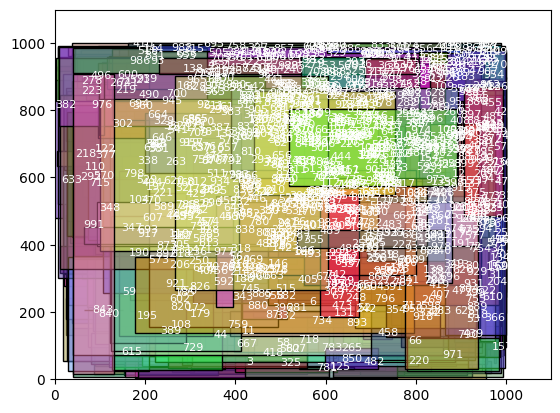

Enter x coordinate: 3000
Enter y coordinate: 4
Naive
825 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 1000 loops each)
RTree
19.1 µs ± 0 ns per loop (mean ± std. dev. of 1 run, 10000 loops each)
The point (3000.0, 4.0) is not enclosed in any rectangle.
The point (3000.0, 4.0) is not enclosed in any rectangle.
Non-overlapping rectangles: []
293 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)
Overlapping rectangles: {1: [4, 5, 6, 7, 8, 9, 12, 13, 14, 16, 17, 18, 19, 20, 22, 23, 25, 26, 27, 30, 33, 35, 36, 37, 38, 39, 40, 41, 43, 45, 46, 47, 48, 51, 54, 55, 56, 57, 60, 61, 62, 63, 64, 68, 69, 70, 71, 72, 74, 75, 76, 78, 79, 80, 81, 83, 84, 86, 88, 89, 90, 91, 92, 94, 95, 96, 98, 99, 100, 101, 102, 103, 105, 107, 109, 112, 114, 116, 117, 120, 121, 123, 124, 126, 127, 128, 129, 130, 132, 133, 135, 136, 137, 138, 139, 140, 141, 142, 145, 146, 147, 148, 149, 150, 151, 154, 155, 156, 158, 159, 161, 162, 164, 165, 168, 169, 170, 171, 173, 174, 175, 176, 178, 180, 181, 182, 183, 18

In [ ]:
def main():
    # Upload your_file.txt
    uploaded = files.upload()

    # Get the name of the uploaded file
    file_name = list(uploaded.keys())[0]

    # Create a file-like object from the uploaded content
    file_content = uploaded[file_name].decode('utf-8')
    rectangles = read_rectangles_from_file(io.StringIO(file_content))

    # Extract maximum x and y values from the dataset so as to set the axes
    max_x = max(rect[3] for rect in rectangles)  # Maximum right_top_corner_x
    max_y = max(rect[4] for rect in rectangles)  # Maximum right_top_corner_y

    # Create an R-tree index
    p = rtree_index.Property()
    rtree_idx = rtree_index.Index(properties=p)

    # Batch insert into R-tree
    batch_size = 2000  # Adjust the batch size based on your available memory
    for i in range(0, len(rectangles), batch_size):
        batch = rectangles[i:i+batch_size]
        batch_insert_rtree(rtree_idx, batch)

    # Plot the rectangles
    fig, ax = plt.subplots()
    ax.set_xlim(0, max_x + (0.1*max_x))  # Set x-axis limit based on maximum x value
    ax.set_ylim(0, max_y + (0.1*max_y))  # Set y-axis limit based on maximum y value

    for index, set_of_numbers in enumerate(rectangles, start=1):
        rect_instance = RectDetails(*set_of_numbers)
        block_left_bottom = (rect_instance.left_bottom_corner_x, rect_instance.left_bottom_corner_y)
        size = [rect_instance.right_top_corner_x - rect_instance.left_bottom_corner_x,
                rect_instance.right_top_corner_y - rect_instance.left_bottom_corner_y]

        plot_rect(ax, block_left_bottom, size, index)

    plt.show()

    x = float(input("Enter x coordinate: "))
    y = float(input("Enter y coordinate: "))
    point = (x, y)
    print("Naive")
    %timeit -r 1 -o find_enclosing_rectangles(point, rectangles)
    enclosing_rectangles_naive = find_enclosing_rectangles(point, rectangles)
    enclosing_rectangles_naive.sort()

    print("RTree")
    %timeit -r 1 -o find_enclosing_rectangles_rtree(point, rtree_idx)
    enclosing_rectangles_rtree = find_enclosing_rectangles_rtree(point, rtree_idx)
    enclosing_rectangles_rtree.sort()

    if enclosing_rectangles_naive:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_naive}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")

    if enclosing_rectangles_rtree:
        print(f"The point {point} is enclosed in the rectangles: {enclosing_rectangles_rtree}")
    else:
        print(f"The point {point} is not enclosed in any rectangle.")

    non_overlapping_ids = non_overlapping_rectangles_naive(rectangles)
    print("Non-overlapping rectangles:", non_overlapping_ids)

    %timeit -r 1 -o find_overlapping_rectangles(rectangles)
    overlapping_rectangles = find_overlapping_rectangles(rectangles)
    print("Overlapping rectangles:", overlapping_rectangles)

    %timeit -r 1 -o find_overlapping_rectangles_rtree(rectangles, rtree_idx)
    overlapping_rectangles_rtree = find_overlapping_rectangles_rtree(rectangles, rtree_idx)
    print("Overlapping rectangles with R-tree:", overlapping_rectangles_rtree)

    %timeit -r 1 -o find_containing_rectangles(rectangles)
    containing_rectangles = find_containing_rectangles(rectangles)
    print("List of rectangles enclosing other rectangles ",containing_rectangles)


    %timeit -r 1 -o find_abutting_rectangles(rectangles)
    abutting_rect=find_abutting_rectangles(rectangles);
    print(abutting_rect)


# Run the main function
if __name__ == "__main__":
    main()
